In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CHRONOSTRAIN_INI=chronostrain.ini
%env CHRONOSTRAIN_LOG_INI=logging.ini
%env JAX_PLATFORM_NAME=cpu


import itertools
from tqdm.notebook import tqdm
from pathlib import Path
from typing import *

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.transforms as mtransforms
import string
import seaborn as sb

from helpers import *

env: CHRONOSTRAIN_INI=chronostrain.ini
env: CHRONOSTRAIN_LOG_INI=logging.ini
env: JAX_PLATFORM_NAME=cpu


0.002583979328165375


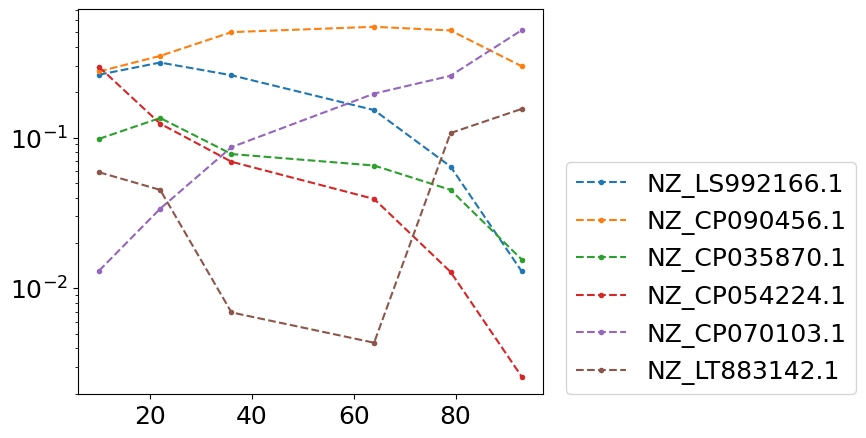

In [3]:
# ============= test
def visualize_example_ground_truth(replicate: int):
    target_accs, time_points, ground_truth = load_ground_truth(mut_ratio="1.0", replicate=replicate)
    print(ground_truth.min())
    colors = sb.color_palette("tab10")
    palette = {acc: colors[i] for i, acc in enumerate(target_accs)}
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    plot_ground_truth(ax, target_accs, time_points, ground_truth, palette, label=True)
    ax.legend(loc=[1.05, 0.0])
    ax.set_yscale('log')

plt.rcParams.update({'font.size': 18})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

visualize_example_ground_truth(replicate=1)
plots_dir = Path() / 'plots'
plots_dir.mkdir(exist_ok=True)
plt.savefig(plots_dir / 'semisynthetic_truth.pdf', format='pdf')

In [4]:
import numpy as np
_, time_points, ground_truth = load_ground_truth(mut_ratio="1.0", replicate=1)

NUM_BINS = 4
ratio_bins = np.histogram_bin_edges(np.log10(ground_truth), bins=NUM_BINS)
print(ratio_bins)

[-2.58771097 -2.00698768 -1.42626439 -0.84554111 -0.26481782]


In [5]:
def compile_mgems(subdir_name: str = 'msweep', lod=0.001):
    df_entries = []
    pbar = tqdm(
        itertools.product(mut_ratios, replicates, read_depths, trials), 
        total=len(mut_ratios) * len(replicates) * len(read_depths) * len(trials),
        desc='mGEMS eval'
    )
    for mut_ratio, replicate, read_depth, trial in pbar:
        try:
            df_entries.append(
                msweep_results(mut_ratio, replicate, read_depth, trial, abundance_bins=ratio_bins, 
                               subdir_name=subdir_name, lod=lod)
            )
            pbar.set_postfix({'n_entries': len(df_entries)})
        except FileNotFoundError as e:
            pass
        except Exception:
            print("[mGEMS] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return pd.DataFrame(df_entries)


def compile_hierarchical_mgems(subdir_name: str = 'mgems', lod=0.001):
    df_entries = []
    pbar = tqdm(
        itertools.product(mut_ratios, replicates, read_depths, trials), 
        total=len(mut_ratios) * len(replicates) * len(read_depths) * len(trials),
        desc='hierarhical mGEMS eval'
    )
    for mut_ratio, replicate, read_depth, trial in pbar:
        try:
            df_entries.append(
                msweep_hierarchical_results(mut_ratio, replicate, read_depth, trial, abundance_bins=ratio_bins, 
                                            subdir_name=subdir_name, lod=lod)
            )
            pbar.set_postfix({'n_entries': len(df_entries)})
        except FileNotFoundError as e:
            pass
        except Exception:
            print("[mGEMS hierarchical] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return pd.DataFrame(df_entries)


def compile_straingst(subdir_name: str = 'straingst'):
    df_entries = []
    pbar = tqdm(
        itertools.product(mut_ratios, replicates, read_depths, trials), 
        total=len(mut_ratios) * len(replicates) * len(read_depths) * len(trials),
        desc='StrainGST eval'
    )
    for mut_ratio, replicate, read_depth, trial in pbar:
        try:
            df_entries.append(
                straingst_results(mut_ratio, replicate, read_depth, trial, abundance_bins=ratio_bins, subdir_name=subdir_name)
            )
            pbar.set_postfix({'n_entries': len(df_entries)})
        except FileNotFoundError as e:
            pass
        except Exception:
            print("[StrainGST] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return pd.DataFrame(df_entries)


def compile_strainest():
    df_entries = []
    pbar = tqdm(
        itertools.product(mut_ratios, replicates, read_depths, trials), 
        total=len(mut_ratios) * len(replicates) * len(read_depths) * len(trials),
        desc='StrainEst eval'
    )
    for mut_ratio, replicate, read_depth, trial in pbar:
        try:
            df_entries.append(
                strainest_results(mut_ratio, replicate, read_depth, trial, abundance_bins=ratio_bins)
            )
            pbar.set_postfix({'n_entries': len(df_entries)})
        except StrainEstInferenceError as e:
            print("[StrainEst] Result has zero abundance. (mut_ratio = {} | replicate = {} | read_depth = {} | trial = {})".format(
                mut_ratio, replicate, read_depth, trial
            ))
            pass
        except FileNotFoundError as e:
            pass
        except Exception:
            print("[StrainEst] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return pd.DataFrame(df_entries)


def compile_chronostrain(subdir_name: str = 'chronostrain', posterior_threshold: float = 0.9901):
    df_entries = []
    pbar = tqdm(
        itertools.product(mut_ratios, replicates, read_depths, trials), 
        total=len(mut_ratios) * len(replicates) * len(read_depths) * len(trials),
        desc='ChronoStrain eval'
    )
    for mut_ratio, replicate, read_depth, trial in pbar:
        try:
            df_entries.append(
                chronostrain_results(mut_ratio, replicate, read_depth, trial, abundance_bins=ratio_bins, subdir_name=subdir_name, posterior_threshold=posterior_threshold)
            )
            pbar.set_postfix({'n_entries': len(df_entries)})
        except FileNotFoundError:
            pass
        except Exception:
            print("[chronostrain] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return pd.DataFrame(df_entries)

In [6]:
mut_ratios = ['1.0']
replicates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
read_depths = [2500, 5000, 10000, 20000, 40000]
trials = [1, 2]


NUM_BACKGROUND_READS = [
    11941733, 12665662, 12996644, 9589266, 9350531, 9685560
]
TOTAL_BACKGROUND_READS = np.sum(NUM_BACKGROUND_READS)



_chrono_tsv_path = Path("plots/chronostrain_res.tsv")
if _chrono_tsv_path.exists():
    chronostrain_err_df = pd.read_csv(_chrono_tsv_path, sep="\t", dtype={'MutRatio': 'str'})
else:
    chronostrain_err_df = compile_chronostrain(posterior_threshold=0.95)  # this takes a while to load.
    chronostrain_err_df.to_csv(_chrono_tsv_path, sep="\t", index=False)
    
# mgems_err_df = compile_mgems(lod=0.0005)
mgems_hierarchical_err_df = compile_hierarchical_mgems(lod=0.001)
straingst_err_df = compile_straingst()
strainest_err_df = compile_strainest()

err_df = pd.concat([
    chronostrain_err_df.assign(
        AUROC=chronostrain_err_df['AUROC_abundance'], 
        AUROC_Collapsed=chronostrain_err_df['AUROC_posterior']
    ), 
    # mgems_err_df,
    mgems_hierarchical_err_df.assign(Method='mGEMS'),
    straingst_err_df, 
    strainest_err_df
], ignore_index=True)
display(err_df)

hierarhical mGEMS eval:   0%|          | 0/100 [00:00<?, ?it/s]

StrainGST eval:   0%|          | 0/100 [00:00<?, ?it/s]

StrainEst eval:   0%|          | 0/100 [00:00<?, ?it/s]

[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 1 | read_depth = 2500 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 1 | read_depth = 2500 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 1 | read_depth = 5000 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 1 | read_depth = 5000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 1 | read_depth = 10000 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 2500 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 2500 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 5000 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 5000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.

,MutRatio,Replicate,ReadDepth,Trial,Method,NumClusters,TVErrorSim,TVErrorA,RMSErrorSim,RMSErrorA,...,RMSErrorSim_Bin2,RMSErrorSim_Bin3,RMSErrorSim_Strain0,RMSErrorSim_Strain1,RMSErrorSim_Strain2,RMSErrorSim_Strain3,RMSErrorSim_Strain4,RMSErrorSim_Strain5,AUROC,AUROC_Collapsed
0,1.0,1,2500,1,ChronoStrain,341,0.170306,0.194341,1.134493,0.214999,...,1.384176,0.935837,2.671332,0.185781,0.332626,0.075631,0.353216,0.557490,0.915395,0.999005
1,1.0,1,2500,2,ChronoStrain,341,0.152735,0.153931,1.173009,0.172140,...,1.806988,0.250128,0.216749,2.794513,0.332808,0.088526,0.473525,0.237885,0.916307,0.999005
2,1.0,1,5000,1,ChronoStrain,341,0.101848,0.103978,0.290842,0.074221,...,0.292968,0.078401,0.225614,0.262724,0.163082,0.044338,0.395051,0.450534,0.999945,1.000000
3,1.0,1,5000,2,ChronoStrain,341,0.094376,0.095595,0.250845,0.074834,...,0.208719,0.109025,0.381207,0.254655,0.269746,0.077508,0.184196,0.233821,0.999876,1.000000
4,1.0,1,10000,1,ChronoStrain,341,0.077207,0.080020,0.324163,0.106213,...,0.145235,0.075882,0.525798,0.324115,0.210379,0.053803,0.219941,0.391722,0.999641,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1.0,10,10000,2,StrainEst,342,0.306849,0.622294,2.069027,0.556672,...,2.738456,1.303127,1.892192,2.794513,1.807082,2.586247,1.488195,1.446230,0.679660,0.799603
347,1.0,10,20000,1,StrainEst,342,0.203389,0.491220,1.643474,0.583529,...,2.217822,0.181769,1.503280,2.794513,1.353670,1.865590,0.115326,0.882134,0.760926,0.887649
348,1.0,10,20000,2,StrainEst,342,0.252732,0.451689,1.581214,0.569295,...,2.061285,0.371800,1.885483,2.243416,1.355484,1.894556,0.414655,0.884563,0.773796,0.972718
349,1.0,10,40000,1,StrainEst,342,0.175450,0.339647,1.309182,0.545353,...,1.482535,0.176113,1.556857,1.833255,1.351265,1.366018,0.196489,0.859357,0.844411,0.999008


# P-values

In [7]:
# Report p-values
import numpy as np
import scipy
import scipy.stats
import statsmodels
import statsmodels.stats.multitest
import itertools


def compute_pvalue_df(metrics_df: pd.DataFrame, base_methods: List[str], comparator_methods: List[str], y_cols: List[str], category: str = 'ReadDepth', alts: List[str] = None):
    pvalue_entries = []
    if alts is None:
        alts = ['two-sided'] * len(y_cols)
    for cat_value, cat_section in metrics_df.groupby(category):
        rd_section = cat_section.sort_values('Trial')
        for method, method2 in itertools.product(base_methods, comparator_methods):
            entry = {
                category: cat_value,
                'Method': method,
                'Comparator': method2
            }
    
            m1 = rd_section.loc[rd_section['Method'] == method, :].sort_values(['Replicate', 'Trial'])
            m2 = rd_section.loc[rd_section['Method'] == method2, :].sort_values(['Replicate', 'Trial'])
            if m2.shape[0] == 0:
                print("Section not available for method `{}` @ {}={}.".format(method2, category, cat_value))
                continue
            
            for y, alt in zip(y_cols, alts):
                a = m1[y].to_numpy()
                b = m2[y].to_numpy()
                
                valid_indices, = np.where(~np.isnan(b))
                a = a[valid_indices]
                b = b[valid_indices]
    
                if len(a) > len(b):
                    b = np.concatenate([b, b[-1] * np.ones(len(a) - len(b))])
    
                statistic, pvalue = scipy.stats.wilcoxon(a, b, alternative=alt)
                    
                entry[f'Pval_{y}'] = pvalue
            pvalue_entries.append(entry)
    pvalues = pd.DataFrame(pvalue_entries)
    
    for col in pvalues.columns:
        if col.startswith('Pval'):
            nan_locs = pvalues[col].isna()

            # only evaluate using non-nan values.
            rej, pval_bh = statsmodels.stats.multitest.fdrcorrection(pvalues.loc[~nan_locs, col].to_numpy(), alpha=0.05, method='p') ## alpha doesn't matter here, we want to output raw p-values with multiple-hypothesis correction
            pvalues.loc[~nan_locs, f'{col}_Raw'] = pvalues[col]
            pvalues.loc[~nan_locs, col] = pval_bh
    return pvalues

In [8]:
pvalues = compute_pvalue_df(
    err_df, 
    base_methods=['ChronoStrain'],
    comparator_methods=['mGEMS', 'StrainGST', 'StrainEst'], 
    y_cols=['TVErrorSim', 'TVErrorA', 'RMSErrorSim', 'RMSErrorA', 'RankCorrelationSim', 'RankCorrelationA', 'AUROC']
)
display(pvalues)
pvalues.to_csv(plots_dir / "pvalues.tsv", sep="\t", index=False)

Section not available for method `StrainEst` @ ReadDepth=2500.
Section not available for method `StrainEst` @ ReadDepth=5000.


,ReadDepth,Method,Comparator,Pval_TVErrorSim,Pval_TVErrorA,Pval_RMSErrorSim,Pval_RMSErrorA,Pval_RankCorrelationSim,Pval_RankCorrelationA,Pval_AUROC,Pval_TVErrorSim_Raw,Pval_TVErrorA_Raw,Pval_RMSErrorSim_Raw,Pval_RMSErrorA_Raw,Pval_RankCorrelationSim_Raw,Pval_RankCorrelationA_Raw,Pval_AUROC_Raw
0,2500,ChronoStrain,mGEMS,0.647655,0.000015,0.000005,0.000004,0.000006,0.000005,0.000009,0.647655,0.000010,0.000002,0.000002,0.000002,0.000002,0.000006
1,2500,ChronoStrain,StrainGST,0.002441,0.000004,0.000022,0.000004,0.018096,0.000008,0.000004,0.001690,0.000002,0.000013,0.000002,0.015312,0.000004,0.000002
2,5000,ChronoStrain,mGEMS,0.645471,0.000052,0.000022,0.000004,0.000022,0.000005,0.000056,0.595819,0.000036,0.000013,0.000002,0.000013,0.000002,0.000048
3,5000,ChronoStrain,StrainGST,0.000012,0.000004,0.000145,0.000004,0.189348,0.001322,0.000004,0.000006,0.000002,0.000134,0.000002,0.189348,0.001017,0.000002
4,10000,ChronoStrain,mGEMS,0.016092,0.189348,0.000107,0.000007,0.000006,0.000005,0.000056,0.013617,0.189348,0.000082,0.000004,0.000002,0.000002,0.000048
5,10000,ChronoStrain,StrainGST,0.000005,0.000004,0.000124,0.000015,0.143787,0.062836,0.000028,0.000002,0.000002,0.000105,0.000010,0.132727,0.053169,0.000019
6,10000,ChronoStrain,StrainEst,0.001587,0.001270,0.000977,0.001058,0.003809,0.001322,0.000977,0.000977,0.000977,0.000977,0.000977,0.002930,0.000977,0.000977
7,20000,ChronoStrain,mGEMS,0.008307,0.178703,0.000008,0.001005,0.000039,0.514480,0.000089,0.006390,0.164957,0.000004,0.000851,0.000027,0.474905,0.000082
8,20000,ChronoStrain,StrainGST,0.000005,0.000004,0.000028,0.000136,0.000021,0.674223,0.000007,0.000002,0.000002,0.000019,0.000105,0.000010,0.674223,0.000004
9,20000,ChronoStrain,StrainEst,0.000005,0.000004,0.000005,0.000004,0.000022,0.000005,0.000004,0.000002,0.000002,0.000002,0.000002,0.000013,0.000002,0.000002


# Plots

In [9]:
def add_figure_labels(fig, axes, labels=None):
    """ add A/B/C/D labels """
    if labels is None:
        labels = [string.ascii_lowercase[n] for n in range(len(axes))]
    if len(labels) != len(axes):
        raise ValueError("Number of labels do not match number of axes.")
    for n, _ax in enumerate(axes):
        # _ax.text(-.1, 1.1, string.ascii_uppercase[n], transform=_ax.transAxes, size=20, weight='bold')
        trans = mtransforms.ScaledTranslation(-25/72, -3/72, fig.dpi_scale_trans)
        lbl = labels[n]
        _ax.text(
            0., 1.05, lbl, transform=_ax.transAxes + trans,
            va='bottom', fontfamily='sans-serif', weight='bold', size=15
        )

def annotate_pvalues(
    axes, 
    pvalue_df: pd.DataFrame, 
    err_df: pd.DataFrame, 
    column_name: str,
    sig_level: float, 
    method_order: List[str], 
    marker_str: str = "n.s.", 
    y_offset_factor: float = 0.2, 
    dy: float = None,
    overlap_gap: float = 0.1,
    show_nonsig: bool = True,
    cascade_above: bool = True
):
    """
    Annotate non-significant pairs with a marker.
    :param offset_factor: controls the space between the bracket and the maximal datapoint (if cascade_above is True, otherwise computes the min)
    :param dy: the height of the bracket.
    :param overlap_gap: controls the height difference between overlapping brackets.
    :param show_nonsig: (default = True) if True, shows NONSIGNIFICANT pairs at the specified level.
    :param cascade_above: (default = True) if True, significance brackets cascade UPWARDS (so y-value is incremented) to avoid overlaps. if False, cascades DOWNWARDS instead.
    """
    method_indices = {m: i for i, m in enumerate(method_order)}
    read_depth_indices = {int(r): i for i, r in enumerate(pd.unique(err_df['ReadDepth']))}
    if show_nonsig:
        subsection = pvalue_df.loc[pvalue_df[f'Pval_{column_name}'] >= sig_level, :]
    else:
        subsection = pvalue_df.loc[pvalue_df[f'Pval_{column_name}'] < sig_level, :]
    if dy is None:
        dy = err_df[column_name].max() * 0.03
    overlap_offsets = {r: 0 for r in read_depth_indices.keys()}

    # these are the seaborn x-coordinates per category (not counting offset)
    _spread = np.arange(0, len(method_order), dtype=float)
    _spread = 0.8 * (_spread / len(_spread))
    _spread = _spread - np.mean(_spread)
    def _get_method_xpos(method_name: str, read_depth: int) -> float:
        ri = read_depth_indices[read_depth]
        mi = method_indices[method_name]
        return ri + _spread[mi]

    for base_method, base_method_section in subsection.groupby("Method"):
        for _, row in subsection.iterrows():
            read_depth = int(row['ReadDepth'])
            comparator = row['Comparator']
            x1 = _get_method_xpos(base_method, read_depth)
            x2 = _get_method_xpos(comparator, read_depth)
            if cascade_above:
                y1 = err_df.loc[
                    (err_df['ReadDepth'] == read_depth)
                    & (err_df['Method'].isin({base_method, comparator})),
                    column_name
                ].max() * (1 + y_offset_factor) + (overlap_offsets[read_depth] * overlap_gap)
                y2 = y1 + dy
            else:
                y1 = err_df.loc[
                    (err_df['ReadDepth'] == read_depth)
                    & (err_df['Method'].isin({base_method, comparator})),
                    column_name
                ].min() * (1 - y_offset_factor) - (overlap_offsets[read_depth] * overlap_gap)
                y2 = y1 - dy
            ax.plot([x1, x1, x2, x2], [y1, y2, y2, y1], color='black', linewidth=1.0, linestyle='-')
            ax.text(x=0.5 * (x1+x2), y=y2, s=marker_str, ha='center', va='bottom', size=10.0)
            overlap_offsets[read_depth] += 1
        

## Paper-specific subplots

/tmp/ipykernel_3729005/16273674.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


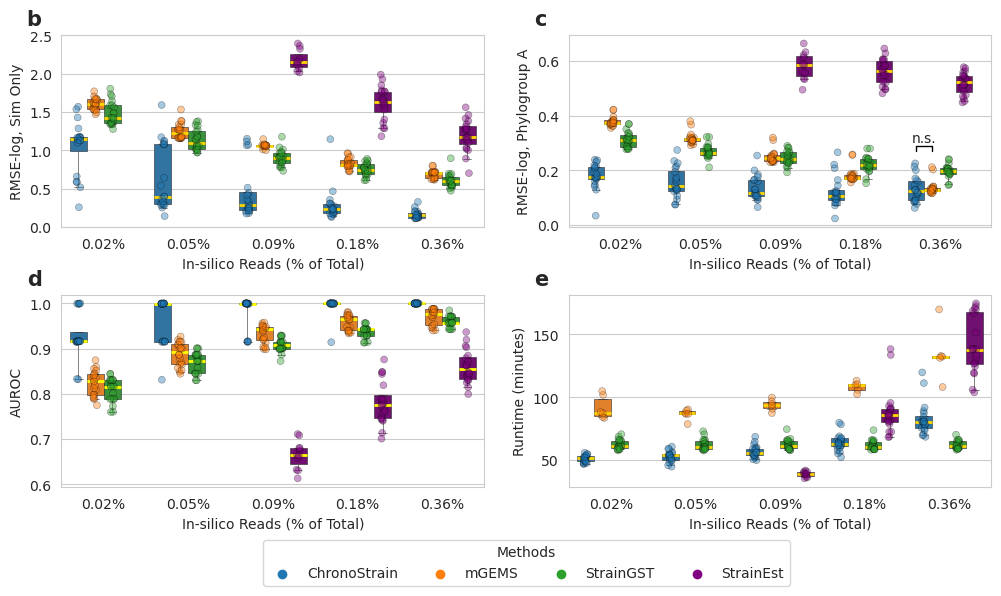

In [11]:
# fig, axes = plt.subplots(3, 4, figsize=(20, 10), height_ratios=[1, 10, 10])
fig = plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
gs = gridspec.GridSpec(ncols=2, nrows=3, figure=fig, height_ratios=[10, 10, 1], hspace=0.5, wspace=0.2)

sb.set_style("whitegrid")

method_order = ['ChronoStrain', 'mGEMS', 'StrainGST', 'StrainEst']
colors = sb.color_palette("tab10")
method_palette = {
    'ChronoStrain': colors[0],
    'mGEMS': colors[1],
    'mGEMS-h': 'orangered',
    'StrainGST': colors[2],
    'StrainEst': 'purple',
}


legend_ax = fig.add_subplot(gs[-1, :])
handles, labels = zip(*[
    (legend_ax.scatter([], [], facecolors=method_palette[m]), m) 
    for m in method_order
])
method_legend = legend_ax.legend(handles, labels, title="Methods", bbox_to_anchor=(0.5, -1), loc="lower center", ncol=len(method_order))
legend_ax.axis('off')


err_df['ReadDepthPct'] = (
    100 
    * (err_df['ReadDepth'] * len(NUM_BACKGROUND_READS))
    / (
        (len(NUM_BACKGROUND_READS) * err_df['ReadDepth']) + TOTAL_BACKGROUND_READS
    )
).apply(lambda x: '{:.2f}%'.format(x))
x_order = sorted(pd.unique(err_df['ReadDepthPct']))

axes = []
ax = fig.add_subplot(gs[0, 0])
ax.set_ylabel("RMSE-log, Sim Only")
sb.stripplot(err_df, x='ReadDepthPct', order=x_order, y='RMSErrorSim', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, edgecolor='black', alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(err_df, x='ReadDepthPct', order=x_order, y='RMSErrorSim', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, linewidth=0.4, color='black', showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
annotate_pvalues(ax, pvalues, err_df, 'RMSErrorSim', 0.05, method_order)
ax.set_xlabel('In-silico Reads (% of Total)')
ax.legend([],[], frameon=False)
axes.append(ax)

# =========== "baseline" error --> compare ground truth to random guess (uniform dist.)
# _, _, example_ground_truth = load_ground_truth(mut_ratio="1.0", replicate=1)
# baseline = np.ones(example_ground_truth.shape, dtype=float)
# baseline = baseline / np.sum(baseline, axis=-1, keepdims=True)
# print(example_ground_truth)
# print(baseline)
# baseline_rmse = rms(np.log10(baseline), np.log10(example_ground_truth))
# print(baseline_rmse)
# ax.axhline(baseline_rmse, color='black', alpha=0.3, linestyle='--')

ax = fig.add_subplot(gs[0, 1])
ax.set_ylabel("RMSE-log, Phylogroup A")
sb.stripplot(err_df, x='ReadDepthPct', order=x_order, y='RMSErrorA', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, edgecolor='black', alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(err_df, x='ReadDepthPct', order=x_order, y='RMSErrorA', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, linewidth=0.4, color='black', showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
annotate_pvalues(ax, pvalues, err_df, 'RMSErrorA', 0.05, method_order)
ax.set_xlabel('In-silico Reads (% of Total)')
ax.legend([],[], frameon=False)
axes.append(ax)

ax = fig.add_subplot(gs[1, 0])
ax.set_ylabel("AUROC")
sb.stripplot(err_df, x='ReadDepthPct', order=x_order, y='AUROC', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, edgecolor='black', alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(err_df, x='ReadDepthPct', order=x_order, y='AUROC', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, linewidth=0.4, color='black', showfliers=False, medianprops={"color": "yellow", "linewidth": 2}, whis=(0.025, 0.975))
annotate_pvalues(ax, pvalues, err_df, 'AUROC', 0.05, method_order, y_offset_factor=0.05, dy=0.015)
ax.set_xlabel('In-silico Reads (% of Total)')
ax.legend([],[], frameon=False)
axes.append(ax)

# grouped_result = err_df.loc[err_df['Method'] == 'ChronoStrain'].groupby('ReadDepth')['RankCorrelation'].median()
# ax.plot(np.arange(6), grouped_result.to_numpy())
ax = fig.add_subplot(gs[1, 1])
ax.set_ylabel("Runtime (minutes)")
err_df['RuntimeMinutes'] = err_df['Runtime'] * 0.001 * (1/60) # milliseconds to minutes
sb.stripplot(err_df, x='ReadDepthPct', order=x_order, y='RuntimeMinutes', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, edgecolor='black', alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(err_df, x='ReadDepthPct', order=x_order, y='RuntimeMinutes', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, linewidth=0.4, color='black', showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
ax.set_xlabel('In-silico Reads (% of Total)')
ax.legend([],[], frameon=False)
axes.append(ax)
# ax.set_yscale('log')





add_figure_labels(fig, axes, ['b', 'c', 'd', 'e'])

fig.tight_layout()
plt.savefig(plots_dir / 'semisynthetic_fixed_paper.pdf', format='pdf', bbox_inches='tight')

In [149]:
pvalues[
    ['ReadDepth', 'Method', 'Comparator', 'Pval_RMSErrorSim', 'Pval_RMSErrorA', 'Pval_AUROC', 'Pval_RMSErrorSim_Raw', 'Pval_RMSErrorA_Raw', 'Pval_AUROC_Raw']
].to_csv(plots_dir / "pvalues_semisynthetic_fixed_paper.tsv", sep="\t", index=False)

# Strain-separated RMS-log

In [150]:
n_strains = ground_truth.shape[1]
strain_split_pvalues = compute_pvalue_df(
    err_df, 
    base_methods=['ChronoStrain'],
    comparator_methods=['mGEMS', 'StrainGST', 'StrainEst'], 
    y_cols=[f'RMSErrorSim_Strain{s_idx}' for s_idx in range(n_strains)]
)
display(strain_split_pvalues)
strain_split_pvalues.to_csv(plots_dir / "strain_split_pvalues.tsv", sep="\t", index=False)

Section not available for method `StrainEst` @ read depth 2500.
Section not available for method `StrainEst` @ read depth 5000.


/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


,ReadDepth,Method,Comparator,Pval_RMSErrorSim_Strain0,Pval_RMSErrorSim_Strain1,Pval_RMSErrorSim_Strain2,Pval_RMSErrorSim_Strain3,Pval_RMSErrorSim_Strain4,Pval_RMSErrorSim_Strain5,Pval_RMSErrorSim_Strain0_Raw,Pval_RMSErrorSim_Strain1_Raw,Pval_RMSErrorSim_Strain2_Raw,Pval_RMSErrorSim_Strain3_Raw,Pval_RMSErrorSim_Strain4_Raw,Pval_RMSErrorSim_Strain5_Raw
0,2500,ChronoStrain,mGEMS,0.032768,0.202450,0.154815,0.002712,0.001048,0.018613,0.032768,0.202450,0.142906,0.002712,0.000322,0.017181
1,2500,ChronoStrain,StrainGST,0.025946,0.000546,0.216167,0.000058,0.123093,0.000248,0.023951,0.000210,0.216167,0.000010,0.123093,0.000134
2,5000,ChronoStrain,mGEMS,0.000466,0.012001,0.154815,0.001101,0.001314,0.063723,0.000322,0.008308,0.142906,0.000708,0.000586,0.063723
3,5000,ChronoStrain,StrainGST,0.004988,0.000012,0.075735,0.000050,0.016092,0.018096,0.004221,0.000002,0.058258,0.000004,0.013617,0.015312
4,10000,ChronoStrain,mGEMS,0.000005,0.047260,0.053248,0.001101,0.001314,0.001150,0.000002,0.039989,0.032768,0.000851,0.000708,0.000708
5,10000,ChronoStrain,StrainGST,0.000273,0.001652,0.069970,0.000117,0.002581,0.004099,0.000168,0.001017,0.048441,0.000063,0.001986,0.003153
6,10000,ChronoStrain,StrainEst,0.001270,0.001652,0.003174,0.001101,0.002581,0.002821,0.000977,0.000977,0.000977,0.000977,0.001953,0.001953
7,20000,ChronoStrain,mGEMS,0.000005,0.047104,0.041673,0.001101,0.001382,0.000005,0.000002,0.036234,0.019234,0.001017,0.000851,0.000002
8,20000,ChronoStrain,StrainGST,0.000021,0.000341,0.003174,0.000117,0.025946,0.000005,0.000010,0.000105,0.000851,0.000048,0.023951,0.000002
9,20000,ChronoStrain,StrainEst,0.000005,0.000012,0.000471,0.000117,0.001314,0.000005,0.000002,0.000002,0.000036,0.000063,0.000625,0.000002


/tmp/ipykernel_2591991/3418872801.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


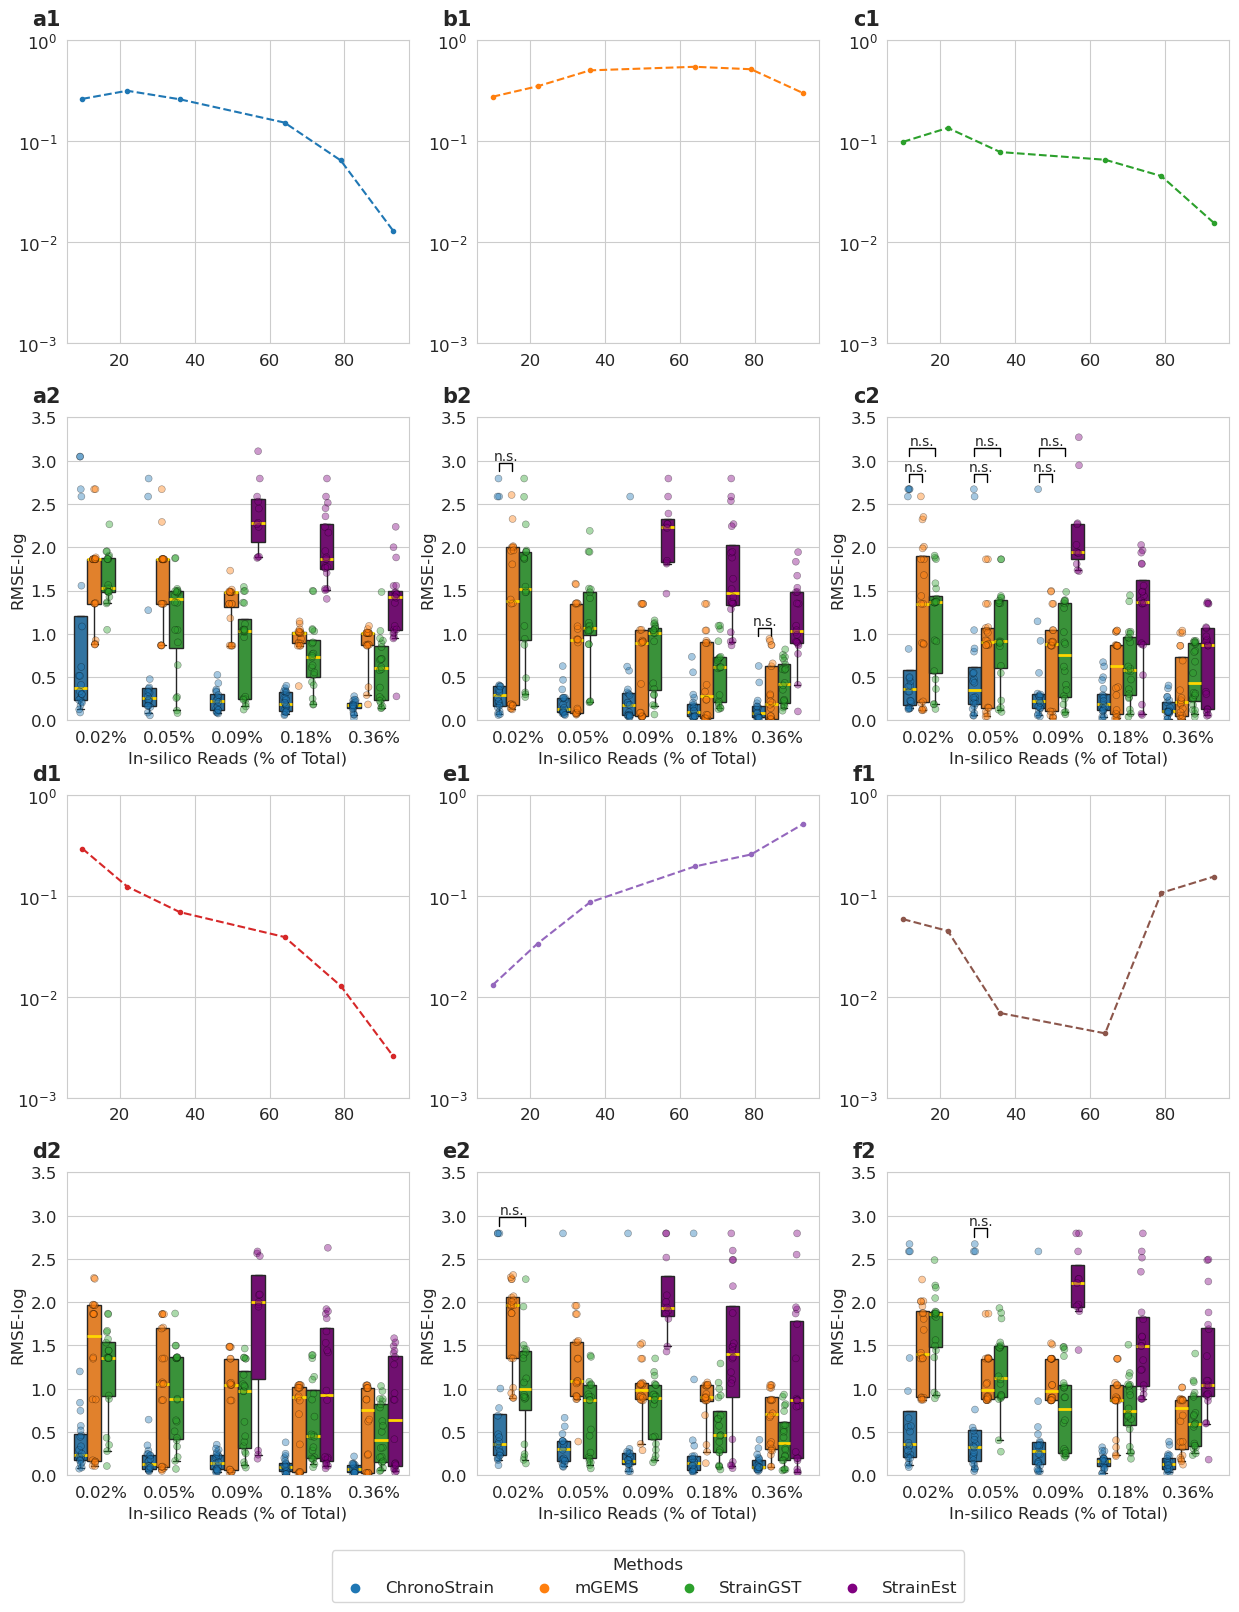

In [155]:
n_strains = ground_truth.shape[1]
assert n_strains == 6  # plot layout is 3x2, which hard-codes the assumption that there are six ground-truth strains.

width, height = (15, 20)
fig = plt.figure(figsize=(width, height))

plt.rcParams.update({'font.size': 12})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
gs = gridspec.GridSpec(ncols=3, nrows=1+4, figure=fig, height_ratios=[10, 10, 10, 10, 1], hspace=0.3, wspace=0.2)
sb.set_style("whitegrid")


method_order = ['ChronoStrain', 'mGEMS', 'StrainGST', 'StrainEst']
colors = sb.color_palette("tab10")
method_palette = {
    'ChronoStrain': colors[0],
    'mGEMS': colors[1],
    'mGEMS-h': 'orangered',
    'StrainGST': colors[2],
    'StrainEst': 'purple',
}


axes = []
legend_ax = fig.add_subplot(gs[-1, :])
handles, labels = zip(*[
    (legend_ax.scatter([], [], facecolors=method_palette[m]), m) 
    for m in method_order
])
method_legend = legend_ax.legend(handles, labels, title="Methods", bbox_to_anchor=(0.5, -1), loc="lower center", ncol=5)
legend_ax.axis('off')


err_df['ReadDepthPct'] = (
    100 
    * (err_df['ReadDepth'] * len(NUM_BACKGROUND_READS))
    / (
        (len(NUM_BACKGROUND_READS) * err_df['ReadDepth']) + TOTAL_BACKGROUND_READS
    )
).apply(lambda x: '{:.2f}%'.format(x))
x_order = sorted(pd.unique(err_df['ReadDepthPct']))


# === plot truth
colors = sb.color_palette("tab10")
for i in range(n_strains):
    c = colors[i]
    traj = ground_truth[:, i]
    if i < 3:
        ax = fig.add_subplot(gs[0, i])
    else:
        ax = fig.add_subplot(gs[2, i-3])
    ax.plot(time_points, traj, color=c, linestyle='--', marker='.', lw=1.5)
    ax.set_ylim(1e-3, 1.0)
    ax.set_yscale('log')
    axes.append(ax)

for s_idx in range(n_strains):
    if s_idx < 3:
        ax = fig.add_subplot(gs[1, s_idx])
    else:
        ax = fig.add_subplot(gs[3, s_idx-3])
    # ax.set_title(f"Strain idx {s_idx}")
    ax.set_ylabel('RMSE-log')
    ax.set_xlabel('In-silico Reads (% of Total)')
    sb.stripplot(err_df, x='ReadDepthPct', order=x_order, y=f'RMSErrorSim_Strain{s_idx}', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, alpha=0.4, hue_order=method_order, palette=method_palette, edgecolor='black')
    sb.boxplot(err_df, x='ReadDepthPct', order=x_order, y=f'RMSErrorSim_Strain{s_idx}', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
    annotate_pvalues(ax, strain_split_pvalues, err_df, f'RMSErrorSim_Strain{s_idx}', 0.05, method_order, y_offset_factor=0.03, dy=0.1, overlap_gap=0.30)
    ax.legend([],[], frameon=False)
    axes.append(ax)
    ax.set_ylim(0, 3.5)





add_figure_labels(fig, axes, ['a1', 'b1', 'c1', 'd1', 'e1', 'f1'] + ['a2', 'b2', 'c2', 'd2', 'e2', 'f2'])
plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)

fig.tight_layout()
plt.savefig(plots_dir / 'semisynthetic_RMSE_split_by_strain.pdf', format='pdf', bbox_inches='tight')

# Binned RMS-log

In [157]:
n_bins = len(ratio_bins) - 1
n_strains = ground_truth.shape[1]
binned_abundance_pvalues = compute_pvalue_df(
    err_df, 
    base_methods=['ChronoStrain'],
    comparator_methods=['mGEMS', 'StrainGST', 'StrainEst'], 
    y_cols=[f'RMSErrorSim_Bin{bin_idx}' for bin_idx in range(n_bins)]
)
display(binned_abundance_pvalues)
binned_abundance_pvalues.to_csv(plots_dir / "binned_abundance_pvalues.tsv", sep="\t", index=False)

Section not available for method `StrainEst` @ read depth 2500.
Section not available for method `StrainEst` @ read depth 5000.


/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


,ReadDepth,Method,Comparator,Pval_RMSErrorSim_Bin0,Pval_RMSErrorSim_Bin1,Pval_RMSErrorSim_Bin2,Pval_RMSErrorSim_Bin3,Pval_RMSErrorSim_Bin0_Raw,Pval_RMSErrorSim_Bin1_Raw,Pval_RMSErrorSim_Bin2_Raw,Pval_RMSErrorSim_Bin3_Raw
0,2500,ChronoStrain,mGEMS,0.000143,0.000003,0.000017,0.000679,0.000132,0.000002,0.000004,0.000261
1,2500,ChronoStrain,StrainGST,0.000143,0.000003,0.002746,0.012632,0.000132,0.000002,0.001690,0.010689
2,5000,ChronoStrain,mGEMS,0.000003,0.000003,0.001888,0.009484,0.000002,0.000002,0.001017,0.007296
3,5000,ChronoStrain,StrainGST,0.000003,0.000003,0.123486,0.230513,0.000002,0.000002,0.113987,0.230513
4,10000,ChronoStrain,mGEMS,0.000003,0.000003,0.123486,0.000698,0.000002,0.000002,0.105398,0.000322
5,10000,ChronoStrain,StrainGST,0.000003,0.000005,0.701181,0.063113,0.000002,0.000004,0.701181,0.058258
6,10000,ChronoStrain,StrainEst,0.000977,0.000977,0.001888,0.001587,0.000977,0.000977,0.000977,0.000977
7,20000,ChronoStrain,mGEMS,0.000003,0.000003,0.022336,0.004554,0.000002,0.000002,0.017181,0.003153
8,20000,ChronoStrain,StrainGST,0.000003,0.000283,0.001840,0.000006,0.000002,0.000261,0.000708,0.000002
9,20000,ChronoStrain,StrainEst,0.000003,0.000003,0.000012,0.000006,0.000002,0.000002,0.000002,0.000002


/tmp/ipykernel_2591991/317875270.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


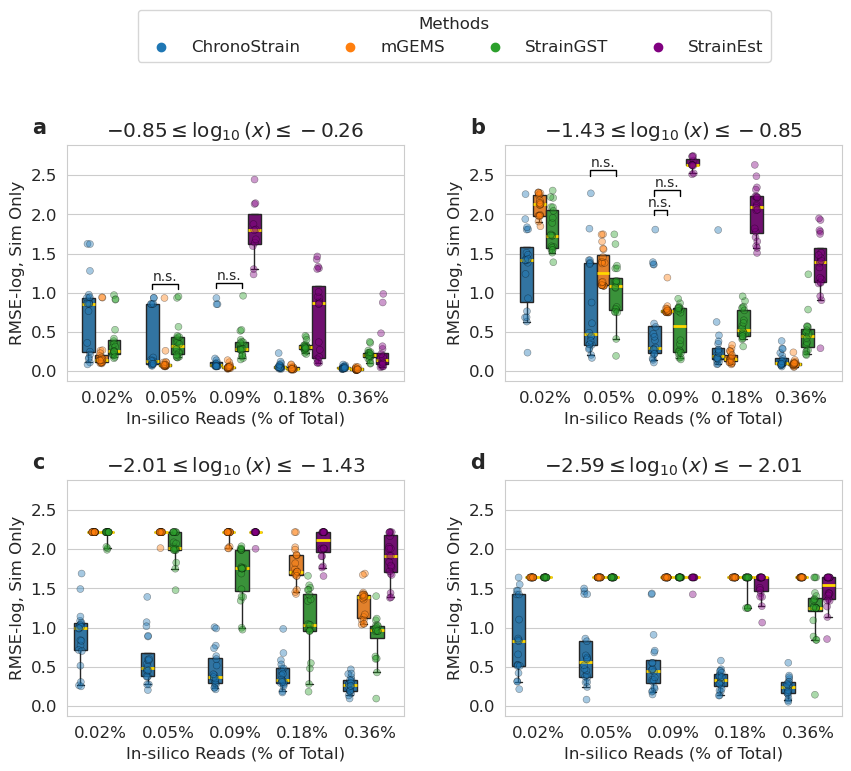

In [158]:
n_bins = len(ratio_bins) - 1
n_cols = 2
n_rows = int(np.ceil(n_bins / n_cols))

width, height = (n_rows * 5, 1 + n_cols * 4)
fig = plt.figure(figsize=(width, height))

plt.rcParams.update({'font.size': 12})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gs = gridspec.GridSpec(ncols=n_cols, nrows=1 + n_rows, figure=fig, height_ratios=[1] + [10] * n_rows, hspace=0.6, wspace=0.3)
sb.set_style("whitegrid")


# method_order = ['ChronoStrain', 'mSWEEP', 'StrainGST', 'StrainEst']
# method_colors = sb.color_palette("tab10")
# method_palette = {m: c for m, c in zip(method_order, method_colors)}
method_order = ['ChronoStrain', 'mGEMS', 'StrainGST', 'StrainEst']
colors = sb.color_palette("tab10")
# method_palette = {m: c for m, c in zip(method_order, colors)}
method_palette = {
    'ChronoStrain': colors[0],
    'mGEMS': colors[1],
    'mGEMS-h': 'orangered',
    'StrainGST': colors[2],
    'StrainEst': 'purple',
}


axes = []
legend_ax = fig.add_subplot(gs[0, :])
handles, labels = zip(*[
    (legend_ax.scatter([], [], facecolors=method_palette[m]), m) 
    for m in method_order
])
method_legend = legend_ax.legend(handles, labels, title="Methods", bbox_to_anchor=(0.5, -1), loc="lower center", ncol=5)
legend_ax.axis('off')


err_df['ReadDepthPct'] = (
    100 
    * (err_df['ReadDepth'] * len(NUM_BACKGROUND_READS))
    / (
        (len(NUM_BACKGROUND_READS) * err_df['ReadDepth']) + TOTAL_BACKGROUND_READS
    )
).apply(lambda x: '{:.2f}%'.format(x))
x_order = sorted(pd.unique(err_df['ReadDepthPct']))


remaining_grid = [
    gs[i+1, j]
    for i in range(n_rows)
    for j in range(n_cols)
]
for bin_idx, ax_grid in zip(range(n_bins), remaining_grid[::-1]):  # note: undo this flip later.
    ax = fig.add_subplot(ax_grid)
    bin_left = ratio_bins[bin_idx]
    bin_right = ratio_bins[bin_idx + 1]
    ax.set_title(r"${:.2f}".format(bin_left) + r"\leq \log_{10}(x)" + r"\leq {:.2f}$".format(bin_right))
    sb.stripplot(err_df, x='ReadDepthPct', order=x_order, y=f'RMSErrorSim_Bin{bin_idx}', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, alpha=0.4, hue_order=method_order, palette=method_palette, edgecolor='black')
    sb.boxplot(err_df, x='ReadDepthPct', order=x_order, y=f'RMSErrorSim_Bin{bin_idx}', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
    annotate_pvalues(ax, binned_abundance_pvalues, err_df, f'RMSErrorSim_Bin{bin_idx}', 0.05, method_order, y_offset_factor=0.10, dy=0.07, overlap_gap=0.25)
    ax.set_xlabel('In-silico Reads (% of Total)')
    ax.set_ylabel('RMSE-log, Sim Only')
    ax.legend([],[], frameon=False)
    axes.append(ax)
    
axes = axes[::-1]  # we flipped the axes order.
for ax in axes:
    ax.sharey(axes[2])


add_figure_labels(fig, axes, list('abcdefghijkl')[:len(axes)])
plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)

fig.tight_layout()
plt.savefig(plots_dir / 'semisynthetic_RMSE_binned_by_abundance.pdf', format='pdf', bbox_inches='tight')

# AUROC, both ways

/tmp/ipykernel_2545027/2481595694.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


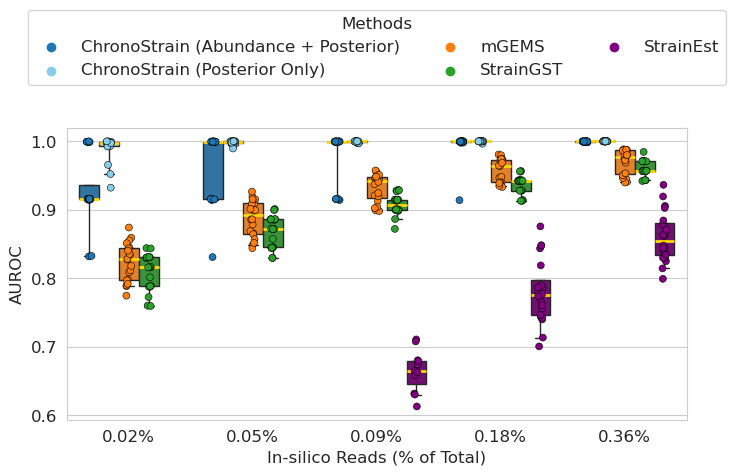

In [18]:
# fig, axes = plt.subplots(3, 4, figsize=(20, 10), height_ratios=[1, 10, 10])
width, height = (8, 5)
fig = plt.figure(figsize=(width, height))
plt.rcParams.update({'font.size': 12})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[1, 10], hspace=0.4, wspace=0.2)

sb.set_style("whitegrid")

# err_df = pd.concat([msweep_err_df, chronostrain_err_df, straingst_err_df, strainest_err_df], ignore_index=True)
auroc_comparison_err_df = pd.concat([
    # mgems_err_df,
    mgems_hierarchical_err_df.assign(Method='mGEMS'),
    chronostrain_err_df.assign(
        AUROC=chronostrain_err_df['AUROC_abundance'],
        Method='ChronoStrain (Abundance + Posterior)'
    ), 
    chronostrain_err_df.assign(
        AUROC=chronostrain_err_df['AUROC_posterior'],
        Method='ChronoStrain (Posterior Only)'
    ),
    straingst_err_df, 
    strainest_err_df
], ignore_index=True)


auroc_comparison_err_df['ReadDepthPct'] = (
    100 
    * (auroc_comparison_err_df['ReadDepth'] * len(NUM_BACKGROUND_READS))
    / (
        (len(NUM_BACKGROUND_READS) * auroc_comparison_err_df['ReadDepth']) + TOTAL_BACKGROUND_READS
    )
).apply(lambda x: '{:.2f}%'.format(x))
x_order = sorted(pd.unique(err_df['ReadDepthPct']))


# method_order = ['ChronoStrain (Abundance + Posterior)', 'ChronoStrain (Posterior Only)', 'mSWEEP', 'StrainGST', 'StrainEst']
# method_colors = sb.color_palette("tab10")
# method_palette = {'ChronoStrain (Abundance + Posterior)': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
#  'ChronoStrain (Posterior Only)': 'skyblue',
#  'mSWEEP': (1.0, 0.4980392156862745, 0.054901960784313725),
#  'StrainGST': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
#  'StrainEst': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)}


method_order = ['ChronoStrain (Abundance + Posterior)', 'ChronoStrain (Posterior Only)', 'mGEMS', 'StrainGST', 'StrainEst']
colors = sb.color_palette("tab10")
# method_palette = {m: c for m, c in zip(method_order, colors)}
method_palette = {
    'ChronoStrain (Abundance + Posterior)': colors[0],
    'ChronoStrain (Posterior Only)': 'skyblue',
    'mGEMS': colors[1],
    'mGEMS-h': 'orangered',
    'StrainGST': colors[2],
    'StrainEst': 'purple',
}


legend_ax = fig.add_subplot(gs[0, :])
handles, labels = zip(*[
    (legend_ax.scatter([], [], facecolors=method_palette[m]), m) 
    for m in method_order
])
method_legend = legend_ax.legend(handles, labels, title="Methods", bbox_to_anchor=(0.5, -1), loc="lower center", ncol=3)
legend_ax.axis('off')

axes = []

# grouped_result = err_df.loc[err_df['Method'] == 'ChronoStrain'].groupby('ReadDepth')['RankCorrelation'].median()
# ax.plot(np.arange(6), grouped_result.to_numpy())
ax = fig.add_subplot(gs[1, 0])
# ax.set_title("AUROC")
sb.stripplot(auroc_comparison_err_df, order=x_order, x='ReadDepthPct', y='AUROC', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, alpha=1.0, hue_order=method_order, palette=method_palette, edgecolor='black')
sb.boxplot(auroc_comparison_err_df, order=x_order, x='ReadDepthPct', y='AUROC', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
ax.set_xlabel('In-silico Reads (% of Total)')
ax.legend([],[], frameon=False)
axes.append(ax)



plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)
fig.tight_layout()
plt.savefig(plots_dir / 'auroc_both.pdf')

# ROC curves

In [42]:
import numpy as np

def get_mgems_roc(mut_ratio: str, read_depth: int):
    pbar = tqdm(
        itertools.product(replicates, trials), 
        total=len(replicates) * len(trials),
        desc='mSWEEP ROC'
    )

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tprs = []
    
    for replicate, trial in pbar:
        try:
            fpr, tpr = msweep_roc(mut_ratio, replicate, read_depth, trial)
            mean_tpr = np.interp(fpr_grid, fpr, tpr)
            mean_tprs.append(mean_tpr)
        except FileNotFoundError:
            pass
        except Exception:
            print("[mSWEEP] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return fpr_grid, np.array(mean_tprs)


def get_mgems_hierarchical_roc(mut_ratio: str, read_depth: int):
    pbar = tqdm(
        itertools.product(replicates, trials), 
        total=len(replicates) * len(trials),
        desc='mGEMS ROC'
    )

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tprs = []
    
    for replicate, trial in pbar:
        try:
            fpr, tpr = msweep_hierarchical_roc(mut_ratio, replicate, read_depth, trial)
            mean_tpr = np.interp(fpr_grid, fpr, tpr)
            mean_tprs.append(mean_tpr)
        except FileNotFoundError:
            pass
        except Exception:
            print("[mSWEEP hierarchical] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return fpr_grid, np.array(mean_tprs)


def get_chronostrain_roc(mut_ratio: str, read_depth: int, posterior_threshold: float = 0.9901):
    pbar = tqdm(
        itertools.product(replicates, trials), 
        total=len(replicates) * len(trials),
        desc='ChronoStrain ROC'
    )

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tprs = []
    
    for replicate, trial in pbar:
        try:
            fpr, tpr = chronostrain_roc(mut_ratio, replicate, read_depth, trial, posterior_threshold=posterior_threshold)
            mean_tpr = np.interp(fpr_grid, fpr, tpr)
            mean_tprs.append(mean_tpr)
        except FileNotFoundError:
            pass
        except Exception:
            print("[ChronoStrain] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return fpr_grid, np.array(mean_tprs)


def get_straingst_roc(mut_ratio: str, read_depth: int):
    pbar = tqdm(
        itertools.product(replicates, trials), 
        total=len(replicates) * len(trials),
        desc='StrainGST ROC'
    )

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tprs = []
    
    for replicate, trial in pbar:
        try:
            fpr, tpr = straingst_roc(mut_ratio, replicate, read_depth, trial)
            mean_tpr = np.interp(fpr_grid, fpr, tpr)
            mean_tprs.append(mean_tpr)
        except FileNotFoundError as e:
            pass
        except Exception:
            print("[StrainGST] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return fpr_grid, np.array(mean_tprs)


def get_strainest_roc(mut_ratio: str, read_depth: int):
    pbar = tqdm(
        itertools.product(replicates, trials), 
        total=len(replicates) * len(trials),
        desc='StrainEst ROC'
    )

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tprs = []
    
    for replicate, trial in pbar:
        try:
            fpr, tpr = strainest_roc(mut_ratio, replicate, read_depth, trial)
            mean_tpr = np.interp(fpr_grid, fpr, tpr)
            mean_tprs.append(mean_tpr)
        except StrainEstInferenceError as e:
            print("[StrainEst] Result has zero abundance. (mut_ratio = {} | replicate = {} | read_depth = {} | trial = {})".format(
                mut_ratio, replicate, read_depth, trial
            ))
            pass
        except FileNotFoundError as e:
            pass
        except Exception:
            print("[StrainEst] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return fpr_grid, np.array(mean_tprs)

In [44]:
roc_curves = {
    read_depth: {
        'ChronoStrain': get_chronostrain_roc("1.0", read_depth, posterior_threshold=0.95),
        'StrainGST': get_straingst_roc("1.0", read_depth),
        'StrainEst': get_strainest_roc("1.0", read_depth),
        # 'mGEMS': get_mgems_roc("1.0", read_depth),
        'mGEMS': get_mgems_hierarchical_roc("1.0", read_depth),
    }
    for read_depth in read_depths
}

ChronoStrain ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainGST ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainEst ROC:   0%|          | 0/20 [00:00<?, ?it/s]

[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 1 | read_depth = 2500 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 1 | read_depth = 2500 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 2500 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 2500 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 3 | read_depth = 2500 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 3 | read_depth = 2500 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 4 | read_depth = 2500 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 4 | read_depth = 2500 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 5 | read_depth = 2500 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0

mGEMS ROC:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainGST ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainEst ROC:   0%|          | 0/20 [00:00<?, ?it/s]

[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 1 | read_depth = 5000 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 1 | read_depth = 5000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 5000 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 5000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 3 | read_depth = 5000 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 3 | read_depth = 5000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 4 | read_depth = 5000 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 4 | read_depth = 5000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 5 | read_depth = 5000 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0

mGEMS ROC:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainGST ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainEst ROC:   0%|          | 0/20 [00:00<?, ?it/s]

[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 10000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 5 | read_depth = 10000 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 5 | read_depth = 10000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 7 | read_depth = 10000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 8 | read_depth = 10000 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 8 | read_depth = 10000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 9 | read_depth = 10000 | trial = 1)


mGEMS ROC:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainGST ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainEst ROC:   0%|          | 0/20 [00:00<?, ?it/s]

mGEMS ROC:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainGST ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainEst ROC:   0%|          | 0/20 [00:00<?, ?it/s]

mGEMS ROC:   0%|          | 0/20 [00:00<?, ?it/s]

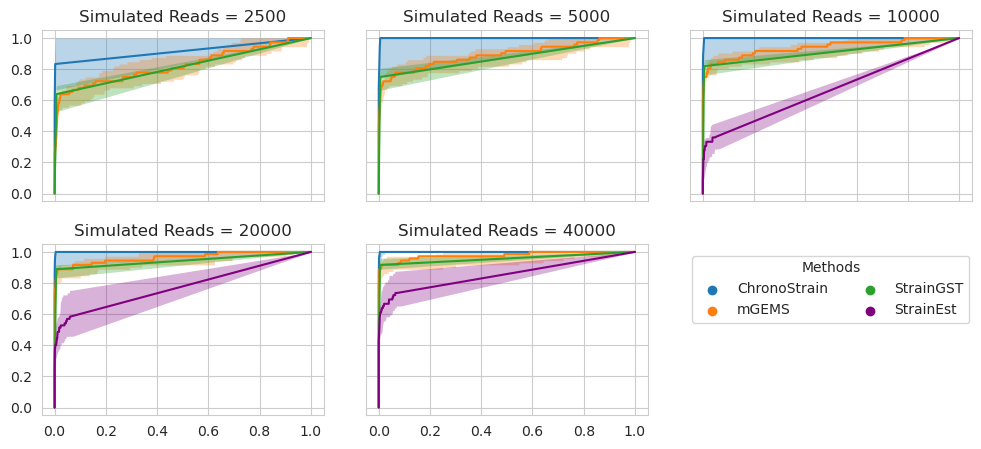

In [45]:
plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(2, 3, figsize=(12, 5), gridspec_kw={'wspace': 0.15, 'hspace': 0.25}, sharex=True, sharey=True)
axes = axes.flatten()

# method_order = ['ChronoStrain', 'mSWEEP', 'StrainGST', 'StrainEst']
# method_colors = sb.color_palette("tab10")
# method_palette = {m: c for m, c in zip(method_order, method_colors)}
method_order = ['ChronoStrain', 'mGEMS', 'StrainGST', 'StrainEst']
colors = sb.color_palette("tab10")
method_palette = {
    'ChronoStrain': colors[0],
    'mGEMS': colors[1],
    'mGEMS-h': 'orangered',
    'StrainGST': colors[2],
    'StrainEst': 'purple',
}

for ax, read_depth in zip(axes, read_depths):
    _rocs = roc_curves[read_depth]
    for method in method_order:
        fprs, mean_tprs = _rocs[method]
        if mean_tprs.shape[0] == 0:
            continue
    
        tpr_lower = np.quantile(mean_tprs, q=0.025, axis=0)
        tpr_upper = np.quantile(mean_tprs, q=0.975, axis=0)
        tpr_median = np.quantile(mean_tprs, q=0.5, axis=0)
        
        fprs = np.concatenate([[0], fprs])
        tpr_lower = np.concatenate([[0], tpr_lower])
        tpr_upper = np.concatenate([[0], tpr_upper])
        tpr_median = np.concatenate([[0], tpr_median])

        color = method_palette[method]
        ax.fill_between(fprs, tpr_lower, tpr_upper, color=color, alpha=0.3, linewidth=0)
        ax.plot(fprs, tpr_median, color=color, linewidth=1.5)
    ax.set_title("Simulated Reads = {}".format(read_depth))

legend_ax = axes[-1]
handles, labels = zip(*[
    (legend_ax.scatter([], [], facecolors=method_palette[m]), m) 
    for m in method_order
])
method_legend = legend_ax.legend(handles, labels, title="Methods", bbox_to_anchor=(0.5, 0.5), loc="lower center", ncol=2)
legend_ax.axis('off')

plt.savefig("plots/ROC_curves.pdf")

# Sensitivity analysis

In [98]:
mut_ratios = ['1.0']
replicates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
read_depths = [10000]
trials = [1, 2]

"""
ChronoStrain
p=0.5: chronostrain_prior1
p=0.1: chronostrain_prior2
p=0.01: chronostrain_prior3
p=0.0001: chronostrain_prior4
note: p=0.001 is the default setting.
"""

chronostrain_dfs = [
    compile_chronostrain('chronostrain_prior1', posterior_threshold=0.99).assign(Method='ChronoStrain (p=0.5,q>0.99)'),
    compile_chronostrain('chronostrain_prior2', posterior_threshold=0.99).assign(Method='ChronoStrain (p=0.1,q>0.99)'),
    compile_chronostrain('chronostrain_prior3', posterior_threshold=0.99).assign(Method='ChronoStrain (p=0.01,q>0.99)'),
    compile_chronostrain('chronostrain', posterior_threshold=0.99).assign(Method='ChronoStrain (p=0.001,q>0.99)'),
    compile_chronostrain('chronostrain_prior4', posterior_threshold=0.99).assign(Method='ChronoStrain (p=0.0001,q>0.99)'),
]

chronostrain_dfs_2 = [
    compile_chronostrain('chronostrain_prior1', posterior_threshold=0.95).assign(Method='ChronoStrain (p=0.5,q>0.95)'),
    compile_chronostrain('chronostrain_prior2', posterior_threshold=0.95).assign(Method='ChronoStrain (p=0.1,q>0.95)'),
    compile_chronostrain('chronostrain_prior3', posterior_threshold=0.95).assign(Method='ChronoStrain (p=0.01,q>0.95)'),
    compile_chronostrain('chronostrain', posterior_threshold=0.95).assign(Method='ChronoStrain (p=0.001,q>0.95)'),
    compile_chronostrain('chronostrain_prior4', posterior_threshold=0.95).assign(Method='ChronoStrain (p=0.0001,q>0.95)'),
]

chronostrain_dfs_3 = [
    compile_chronostrain('chronostrain_prior1', posterior_threshold=0.90).assign(Method='ChronoStrain (p=0.5,q>0.90)'),
    compile_chronostrain('chronostrain_prior2', posterior_threshold=0.90).assign(Method='ChronoStrain (p=0.1,q>0.90)'),
    compile_chronostrain('chronostrain_prior3', posterior_threshold=0.90).assign(Method='ChronoStrain (p=0.01,q>0.90)'),
    compile_chronostrain('chronostrain', posterior_threshold=0.90).assign(Method='ChronoStrain (p=0.001,q>0.90)'),
    compile_chronostrain('chronostrain_prior4', posterior_threshold=0.90).assign(Method='ChronoStrain (p=0.0001,q>0.90)'),
]


"""
strainGST
n20 means "--iters 20"
"""
straingst_dfs = [
    compile_straingst('straingst').assign(Method='StrainGST (n=10,score>0.00)'),
    compile_straingst('straingst_n20').assign(Method='StrainGST (n=20,score>0.00)'),
    compile_straingst('straingst_n10_s01').assign(Method='StrainGST (n=10,score>0.01)'),
    compile_straingst('straingst_n10_s02').assign(Method='StrainGST (n=10,score>0.02)'),
    compile_straingst('straingst_n10_s03').assign(Method='StrainGST (n=10,score>0.03)'),
]


# """
# mGEMS
# """
# mgems_dfs = [
#     compile_mgems('msweep', lod=0.1).assign(Method='mGEMS (q=.65,eps=0.1)'),
#     compile_mgems('msweep', lod=0.01).assign(Method='mGEMS (q=.65,eps=0.01)'),
#     compile_mgems('msweep', lod=0.001).assign(Method='mGEMS (q=.65,eps=0.001)'),
#     compile_mgems('msweep', lod=0.0001).assign(Method='mGEMS (q=.65,eps=0.0001)'),
    
#     compile_mgems('msweep_prior1', lod=0.1).assign(Method='mGEMS (q=.5,eps=0.1)'),
#     compile_mgems('msweep_prior1', lod=0.01).assign(Method='mGEMS (q=.5,eps=0.01)'),
#     compile_mgems('msweep_prior1', lod=0.001).assign(Method='mGEMS (q=.5,eps=0.001)'),
#     compile_mgems('msweep_prior1', lod=0.0001).assign(Method='mGEMS (q=.5,eps=0.0001)'),
    
#     compile_mgems('msweep_prior2', lod=0.1).assign(Method='mGEMS (q=.35,eps=0.1)'),
#     compile_mgems('msweep_prior2', lod=0.01).assign(Method='mGEMS (q=.35,eps=0.01)'),
#     compile_mgems('msweep_prior2', lod=0.001).assign(Method='mGEMS (q=.35,eps=0.001)'),
#     compile_mgems('msweep_prior2', lod=0.0001).assign(Method='mGEMS (q=.35,eps=0.0001)'),
    
#     compile_mgems('msweep_prior3', lod=0.1).assign(Method='mGEMS (q=.80,eps=0.1)'),
#     compile_mgems('msweep_prior3', lod=0.01).assign(Method='mGEMS (q=.80,eps=0.01)'),
#     compile_mgems('msweep_prior3', lod=0.001).assign(Method='mGEMS (q=.80,eps=0.001)'),
#     compile_mgems('msweep_prior3', lod=0.0001).assign(Method='mGEMS (q=.80,eps=0.0001)'),
# ]

"""
mGEMS-hierarchical
"""
mgems_hierarchical_dfs = [
    compile_hierarchical_mgems('mgems', lod=0.1).assign(Method='mGEMS (q=.65,eps=0.1)'),
    compile_hierarchical_mgems('mgems', lod=0.01).assign(Method='mGEMS (q=.65,eps=0.01)'),
    compile_hierarchical_mgems('mgems', lod=0.001).assign(Method='mGEMS (q=.65,eps=0.001)'),
    compile_hierarchical_mgems('mgems', lod=0.0001).assign(Method='mGEMS (q=.65,eps=0.0001)'),
    
    compile_hierarchical_mgems('mgems_prior1', lod=0.1).assign(Method='mGEMS (q=.5,eps=0.1)'),
    compile_hierarchical_mgems('mgems_prior1', lod=0.01).assign(Method='mGEMS (q=.5,eps=0.01)'),
    compile_hierarchical_mgems('mgems_prior1', lod=0.001).assign(Method='mGEMS (q=.5,eps=0.001)'),
    compile_hierarchical_mgems('mgems_prior1', lod=0.0001).assign(Method='mGEMS (q=.5,eps=0.0001)'),
    
    compile_hierarchical_mgems('mgems_prior2', lod=0.1).assign(Method='mGEMS (q=.35,eps=0.1)'),
    compile_hierarchical_mgems('mgems_prior2', lod=0.01).assign(Method='mGEMS (q=.35,eps=0.01)'),
    compile_hierarchical_mgems('mgems_prior2', lod=0.001).assign(Method='mGEMS (q=.35,eps=0.001)'),
    compile_hierarchical_mgems('mgems_prior2', lod=0.0001).assign(Method='mGEMS (q=.35,eps=0.0001)'),
    
    compile_hierarchical_mgems('mgems_prior3', lod=0.1).assign(Method='mGEMS (q=.80,eps=0.1)'),
    compile_hierarchical_mgems('mgems_prior3', lod=0.01).assign(Method='mGEMS (q=.80,eps=0.01)'),
    compile_hierarchical_mgems('mgems_prior3', lod=0.001).assign(Method='mGEMS (q=.80,eps=0.001)'),
    compile_hierarchical_mgems('mgems_prior3', lod=0.0001).assign(Method='mGEMS (q=.80,eps=0.0001)'),
]

ChronoStrain eval:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain eval:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain eval:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain eval:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain eval:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain eval:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain eval:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain eval:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain eval:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain eval:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain eval:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain eval:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain eval:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain eval:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain eval:   0%|          | 0/20 [00:00<?, ?it/s]

StrainGST eval:   0%|          | 0/20 [00:00<?, ?it/s]

StrainGST eval:   0%|          | 0/20 [00:00<?, ?it/s]

StrainGST eval:   0%|          | 0/20 [00:00<?, ?it/s]

StrainGST eval:   0%|          | 0/20 [00:00<?, ?it/s]

StrainGST eval:   0%|          | 0/20 [00:00<?, ?it/s]

/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/straingst.py:111: RuntimeWarning: invalid value encountered in divide
  SUBSET_pred = SUBSET_pred / np.sum(SUBSET_pred, axis=-1, keepdims=True)
/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/straingst.py:111: RuntimeWarning: invalid value encountered in divide
  SUBSET_pred = SUBSET_pred / np.sum(SUBSET_pred, axis=-1, keepdims=True)
/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/straingst.py:111: RuntimeWarning: invalid value encountered in divide
  SUBSET_pred = SUBSET_pred / np.sum(SUBSET_pred, axis=-1, keepdims=True)
/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/straingst.py:111: RuntimeWarning: invalid value encountered in divide
  SUBSET_pred = SUBSET_pred / np.sum(SUBSET_pred, axis=-1, keepdims=True)


hierarhical mGEMS eval:   0%|          | 0/20 [00:00<?, ?it/s]

/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/mgems_hierarchical.py:156: RuntimeWarning: invalid value encountered in divide
  A_pred_filtered_renorm = A_pred_filtered_renorm / np.sum(A_pred_filtered_renorm, axis=-1, keepdims=True)
/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/mgems_hierarchical.py:160: RuntimeWarning: invalid value encountered in divide
  sim_pred_filtered_renorm = sim_pred_filtered_renorm / np.sum(sim_pred_filtered_renorm, axis=-1, keepdims=True)
/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/mgems_hierarchical.py:156: RuntimeWarning: invalid value encountered in divide
  A_pred_filtered_renorm = A_pred_filtered_renorm / np.sum(A_pred_filtered_renorm, axis=-1, keepdims=True)
/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/mgems_hierarchical.py:160: RuntimeWarning: invalid value encountered in divide
  sim_pred_filtered_renorm = sim_pred_filtered_renorm / np.sum(sim_pred_filte

hierarhical mGEMS eval:   0%|          | 0/20 [00:00<?, ?it/s]

hierarhical mGEMS eval:   0%|          | 0/20 [00:00<?, ?it/s]

hierarhical mGEMS eval:   0%|          | 0/20 [00:00<?, ?it/s]

hierarhical mGEMS eval:   0%|          | 0/20 [00:00<?, ?it/s]

/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/mgems_hierarchical.py:156: RuntimeWarning: invalid value encountered in divide
  A_pred_filtered_renorm = A_pred_filtered_renorm / np.sum(A_pred_filtered_renorm, axis=-1, keepdims=True)
/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/mgems_hierarchical.py:160: RuntimeWarning: invalid value encountered in divide
  sim_pred_filtered_renorm = sim_pred_filtered_renorm / np.sum(sim_pred_filtered_renorm, axis=-1, keepdims=True)
/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/mgems_hierarchical.py:156: RuntimeWarning: invalid value encountered in divide
  A_pred_filtered_renorm = A_pred_filtered_renorm / np.sum(A_pred_filtered_renorm, axis=-1, keepdims=True)
/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/mgems_hierarchical.py:160: RuntimeWarning: invalid value encountered in divide
  sim_pred_filtered_renorm = sim_pred_filtered_renorm / np.sum(sim_pred_filte

hierarhical mGEMS eval:   0%|          | 0/20 [00:00<?, ?it/s]

hierarhical mGEMS eval:   0%|          | 0/20 [00:00<?, ?it/s]

hierarhical mGEMS eval:   0%|          | 0/20 [00:00<?, ?it/s]

hierarhical mGEMS eval:   0%|          | 0/20 [00:00<?, ?it/s]

/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/mgems_hierarchical.py:156: RuntimeWarning: invalid value encountered in divide
  A_pred_filtered_renorm = A_pred_filtered_renorm / np.sum(A_pred_filtered_renorm, axis=-1, keepdims=True)
/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/mgems_hierarchical.py:160: RuntimeWarning: invalid value encountered in divide
  sim_pred_filtered_renorm = sim_pred_filtered_renorm / np.sum(sim_pred_filtered_renorm, axis=-1, keepdims=True)
/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/mgems_hierarchical.py:156: RuntimeWarning: invalid value encountered in divide
  A_pred_filtered_renorm = A_pred_filtered_renorm / np.sum(A_pred_filtered_renorm, axis=-1, keepdims=True)
/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/mgems_hierarchical.py:160: RuntimeWarning: invalid value encountered in divide
  sim_pred_filtered_renorm = sim_pred_filtered_renorm / np.sum(sim_pred_filte

hierarhical mGEMS eval:   0%|          | 0/20 [00:00<?, ?it/s]

hierarhical mGEMS eval:   0%|          | 0/20 [00:00<?, ?it/s]

hierarhical mGEMS eval:   0%|          | 0/20 [00:00<?, ?it/s]

hierarhical mGEMS eval:   0%|          | 0/20 [00:00<?, ?it/s]

/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/mgems_hierarchical.py:156: RuntimeWarning: invalid value encountered in divide
  A_pred_filtered_renorm = A_pred_filtered_renorm / np.sum(A_pred_filtered_renorm, axis=-1, keepdims=True)
/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/mgems_hierarchical.py:160: RuntimeWarning: invalid value encountered in divide
  sim_pred_filtered_renorm = sim_pred_filtered_renorm / np.sum(sim_pred_filtered_renorm, axis=-1, keepdims=True)
/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/mgems_hierarchical.py:156: RuntimeWarning: invalid value encountered in divide
  A_pred_filtered_renorm = A_pred_filtered_renorm / np.sum(A_pred_filtered_renorm, axis=-1, keepdims=True)
/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/mgems_hierarchical.py:160: RuntimeWarning: invalid value encountered in divide
  sim_pred_filtered_renorm = sim_pred_filtered_renorm / np.sum(sim_pred_filte

hierarhical mGEMS eval:   0%|          | 0/20 [00:00<?, ?it/s]

hierarhical mGEMS eval:   0%|          | 0/20 [00:00<?, ?it/s]

hierarhical mGEMS eval:   0%|          | 0/20 [00:00<?, ?it/s]

In [159]:
extended_err_df = pd.concat(
    [
        x.assign(
            AUROC=x['AUROC_abundance'], 
            AUROC_Collapsed=x['AUROC_posterior']
        ) 
        for x in chronostrain_dfs
    ]
    + [
        x.assign(
            AUROC=x['AUROC_abundance'], 
            AUROC_Collapsed=x['AUROC_posterior']
        ) 
        for x in chronostrain_dfs_2
    ]
    + [
        x.assign(
            AUROC=x['AUROC_abundance'], 
            AUROC_Collapsed=x['AUROC_posterior']
        ) 
        for x in chronostrain_dfs_3
    ]
    + straingst_dfs
    + mgems_hierarchical_dfs,
    ignore_index=True
)

extended_err_df = extended_err_df.drop(columns=['AUROC_abundance', 'AUROC_posterior'])

In [160]:
# Compute pvalues
sensitivity_methods = list(pd.unique(extended_err_df['Method']))

sensitivity_pvalues = compute_pvalue_df(
    extended_err_df, 
    # base_methods=[m for m in sensitivity_methods if m.startswith('ChronoStrain')],
    base_methods=['ChronoStrain (p=0.001,q>0.99)'],
    comparator_methods=[m for m in sensitivity_methods if not m.startswith('ChronoStrain')], 
    y_cols=['RMSErrorSim', 'RMSErrorA', 'AUROC'],
    alts=['two-sided', 'two-sided', 'two-sided']
)

sensitivity_pvalues.to_csv(plots_dir / "sensitivity_comparison_pvalues.tsv", sep="\t", index=False)

/tmp/ipykernel_2591991/2817381780.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


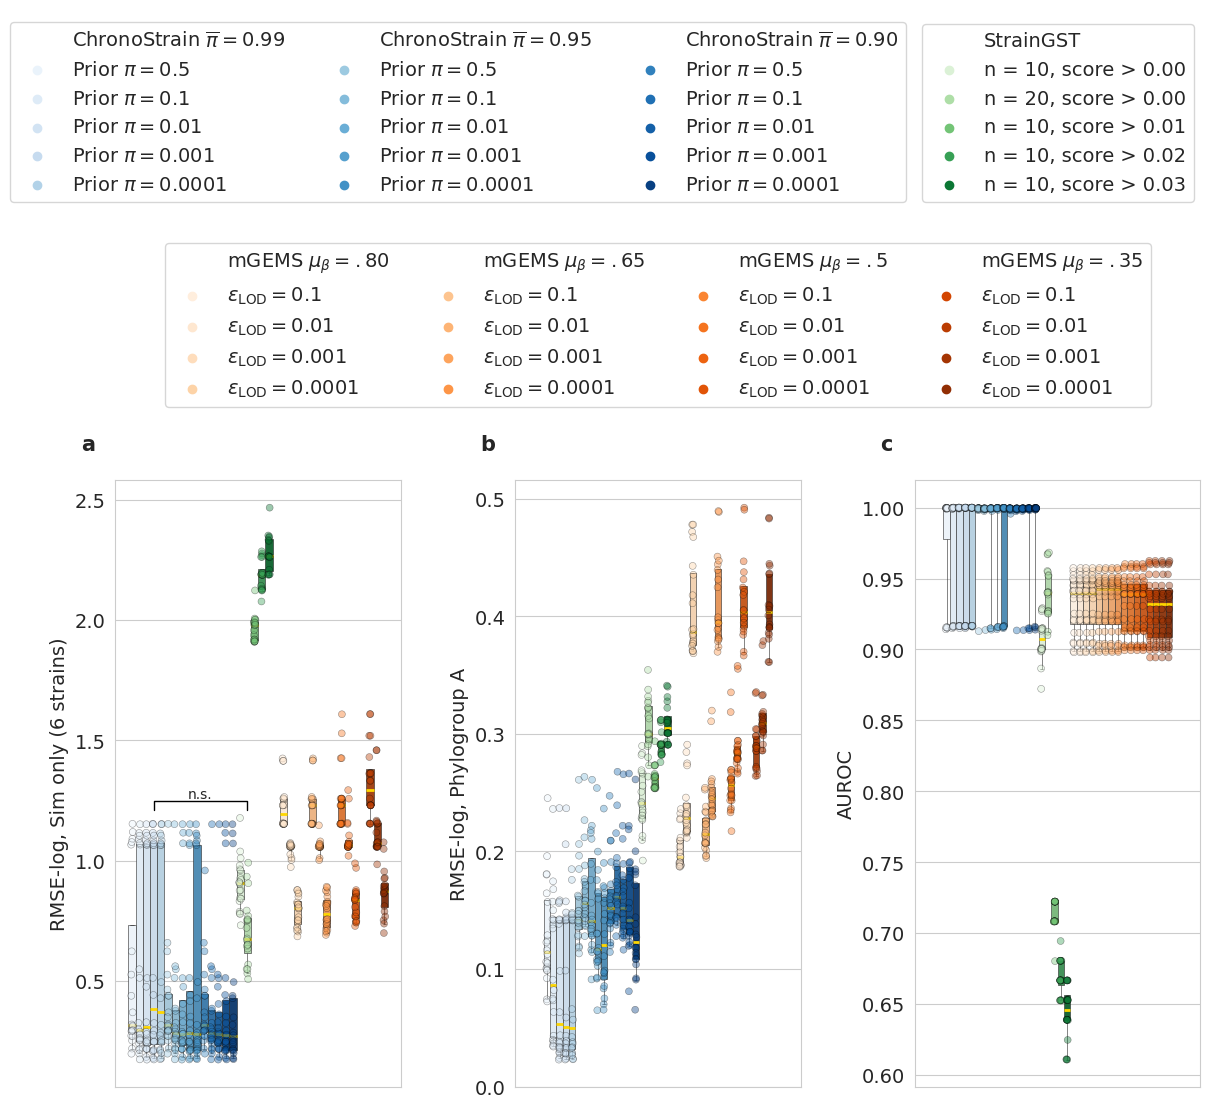

In [161]:
# Render plot
sb.set_style("whitegrid")

fig = plt.figure(figsize=(14, 14))
plt.rcParams.update({'font.size': 14})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
gs = gridspec.GridSpec(ncols=3, nrows=3, figure=fig, height_ratios=[1, 0.7, 3], hspace=0.2, wspace=0.4)

empty_legend_handle = matplotlib.lines.Line2D([], [], marker='None', linestyle='None')


# Determine method order, and render legend.
# == ChronoStrain
legend_ax = fig.add_subplot(gs[0, :2])
legend_ax.axis('off')
legend_handles = []
legend_labels = []

q_range = ["0.99", "0.95", "0.90"]
p_range = ["0.5", "0.1", "0.01", "0.001", "0.0001"]
chronostrain_palette = {}
chronostrain_order = []
chronostrain_colors = iter(sb.color_palette("Blues", len(q_range) * len(p_range)))

for q in q_range:
    legend_labels.append(r"ChronoStrain $\overline{\pi}={s1}$".replace("s1", q))
    legend_handles.append(empty_legend_handle)
    for p in p_range:
        method_name = "ChronoStrain (p={},q>{})".format(p, q)
        chronostrain_order.append(method_name)
        c = next(chronostrain_colors)
        chronostrain_palette[method_name] = c
        
        legend_labels.append(r"Prior $\pi={}$".format(p))
        legend_handles.append(legend_ax.scatter([], [], facecolors=c))
method_legend = legend_ax.legend(
    legend_handles,  # handles
    legend_labels,  # labels
    loc="lower center",
    ncol=3
)

# == StrainGST
legend_ax = fig.add_subplot(gs[0, 2])
legend_ax.axis('off')
legend_handles = []
legend_labels = []

straingst_iters_arr = [
    ("10", "0.00"), 
    ("20", "0.00"),
    ("10", "0.01"),
    ("10", "0.02"),
    ("10", "0.03"),
 ]
straingst_palette = {}
straingst_order = []
straingst_colors = sb.color_palette("Greens", len(straingst_iters_arr))

legend_labels.append('StrainGST')
legend_handles.append(empty_legend_handle)
for (straingst_n_iters, straingst_score_lb), c in zip(straingst_iters_arr, straingst_colors):
    m_name = f'StrainGST (n={straingst_n_iters},score>{straingst_score_lb})'
    straingst_order.append(m_name)
    straingst_palette[m_name] = c
    legend_labels.append(f"n = {straingst_n_iters}, score > {straingst_score_lb}")
    legend_handles.append(legend_ax.scatter([], [], facecolors=c))

assert (len(p_range) - len(straingst_iters_arr)) >= 0
# legend_labels += [''] * (len(p_range) - len(straingst_iters_arr))
# legend_handles += [empty_legend_handle] * (len(p_range) - len(straingst_iters_arr))

method_legend = legend_ax.legend(
    legend_handles,  # handles
    legend_labels,  # labels
    loc="lower center",
    ncol=1
)
    
# == mGEMS
legend_ax = fig.add_subplot(gs[1, :])
legend_ax.axis('off')
legend_handles = []
legend_labels = []

mgems_prior_q = [".80", ".65", ".5", ".35"]
mgems_epsilons_arr = ["0.1", "0.01", "0.001", "0.0001"]
mgems_palette = {}
mgems_order = []
mgems_colors = iter(sb.color_palette("Oranges", len(mgems_epsilons_arr) * len(mgems_prior_q)))

# legend_labels.append('mGEMS')
# legend_handles.append(empty_legend_handle)
for mgems_q in mgems_prior_q:
    legend_labels.append(r"mGEMS $\mu_\beta={}$".format(mgems_q))  # this is the legend display rendered name
    legend_handles.append(empty_legend_handle)
    for mgems_eps in mgems_epsilons_arr:
        m_name = f'mGEMS (q={mgems_q},eps={mgems_eps})'  # this the lookup key for the dataframe
        mgems_order.append(m_name)
        
        c = next(mgems_colors)
        mgems_palette[m_name] = c
        legend_labels.append(r"$\epsilon_\text{arg1}={arg2}$".replace("arg1", "LOD").replace("arg2", mgems_eps))
        legend_handles.append(legend_ax.scatter([], [], facecolors=c))

# assert (len(p_range) - len(mgems_epsilons_arr)) >= 0
# legend_labels += [''] * (len(p_range) - len(mgems_epsilons_arr))
# legend_handles += [empty_legend_handle] * (len(p_range) - len(mgems_epsilons_arr))

method_legend = legend_ax.legend(
    legend_handles,  # handles
    legend_labels,  # labels
    loc="lower center",
    ncol=4
)


method_order = chronostrain_order + straingst_order + mgems_order
method_palette = chronostrain_palette | straingst_palette | mgems_palette
# method_legend = legend_ax.legend(
#     legend_handles,  # handles
#     legend_labels,  # labels
#     loc="lower center",
#     ncol=5
# )


axes = []

ax = fig.add_subplot(gs[-1, 0])
sb.stripplot(extended_err_df, x='ReadDepth', y='RMSErrorSim', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, edgecolor='black', alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(extended_err_df, x='ReadDepth', y='RMSErrorSim', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, 
           linewidth=0.4, color='black', showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))

annotate_pvalues(ax, sensitivity_pvalues, extended_err_df, 'RMSErrorSim', 0.05, method_order, y_offset_factor=0.05, dy=0.035, overlap_gap=0.05)
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel("RMSE-log, Sim only (6 strains)")
ax.legend([],[], frameon=False)
axes.append(ax)

ax = fig.add_subplot(gs[-1, 1])
sb.stripplot(extended_err_df, x='ReadDepth', y='RMSErrorA', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, edgecolor='black', alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(extended_err_df, x='ReadDepth', y='RMSErrorA', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, linewidth=0.4, color='black', showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
annotate_pvalues(ax, sensitivity_pvalues, extended_err_df, 'RMSErrorA', 0.05, method_order, y_offset_factor=0.05, dy=0.035, overlap_gap=0.05)
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel("RMSE-log, Phylogroup A")
ax.legend([],[], frameon=False)
axes.append(ax)

# grouped_result = err_df.loc[err_df['Method'] == 'ChronoStrain'].groupby('ReadDepth')['RankCorrelation'].median()
# ax.plot(np.arange(6), grouped_result.to_numpy())
ax = fig.add_subplot(gs[-1, 2])
sb.stripplot(extended_err_df, x='ReadDepth', y='AUROC', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, edgecolor='black', alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(extended_err_df, x='ReadDepth', y='AUROC', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, linewidth=0.4, color='black', showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
annotate_pvalues(ax, sensitivity_pvalues, extended_err_df, 'AUROC', 0.05, method_order, y_offset_factor=0.05, dy=0.035, overlap_gap=0.05)
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel("AUROC")
ax.legend([],[], frameon=False)
axes.append(ax)


add_figure_labels(fig, axes, ['a', 'b', 'c'])


plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)

fig.tight_layout()
plt.savefig(plots_dir / 'semisynthetic_sensitivity_comparison.pdf', format='pdf', bbox_inches='tight')

# Vary mutation ratios

In [46]:
mut_ratios = ['1.0', '3.0', '5.0', '7.0', '9.0']
replicates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
read_depths = [2500]
trials = [1, 2]

_chr_df = compile_chronostrain(posterior_threshold=0.95)
mutratio_err_df = pd.concat([
    _chr_df.assign(AUROC=_chr_df['AUROC_abundance']),
    # compile_mgems(),
    compile_hierarchical_mgems().assign(Method='mGEMS'),
    compile_straingst()
], ignore_index=True)

mutratio_err_df['MutRatio'] = (mutratio_err_df['MutRatio'].astype(float) * 0.002).apply(lambda x: '{:.3f}'.format(x))

ChronoStrain eval:   0%|          | 0/100 [00:00<?, ?it/s]

hierarhical mGEMS eval:   0%|          | 0/100 [00:00<?, ?it/s]

StrainGST eval:   0%|          | 0/100 [00:00<?, ?it/s]

In [171]:
mutratio_pvalues = compute_pvalue_df(
    mutratio_err_df, 
    category='MutRatio',
    base_methods=['ChronoStrain'],
    comparator_methods=['mGEMS', 'StrainGST'], 
    y_cols=['RMSErrorSim', 'RMSErrorA', 'AUROC']
)
display(mutratio_pvalues)
mutratio_pvalues.to_csv(plots_dir / "mutratio_pvalues.tsv", sep="\t", index=False)

,MutRatio,Method,Comparator,Pval_RMSErrorSim,Pval_RMSErrorA,Pval_AUROC,Pval_RMSErrorSim_Raw,Pval_RMSErrorA_Raw,Pval_AUROC_Raw
0,0.002,ChronoStrain,mGEMS,0.000019,0.000010,0.000029,0.000002,0.000002,0.000006
1,0.002,ChronoStrain,StrainGST,0.000067,0.000010,0.000019,0.000013,0.000002,0.000002
2,0.006,ChronoStrain,mGEMS,0.006510,0.002441,0.004883,0.003906,0.001953,0.003906
3,0.006,ChronoStrain,StrainGST,0.012207,0.002441,0.003906,0.009766,0.001953,0.001953
4,0.010,ChronoStrain,mGEMS,0.006510,0.002441,0.004883,0.003906,0.001953,0.003906
5,0.010,ChronoStrain,StrainGST,0.008371,0.002441,0.004883,0.005859,0.001953,0.003906
6,0.014,ChronoStrain,mGEMS,0.006510,0.002441,0.005859,0.003906,0.001953,0.005859
7,0.014,ChronoStrain,StrainGST,0.021701,0.003906,0.003906,0.019531,0.003906,0.001953
8,0.018,ChronoStrain,mGEMS,0.006510,0.002441,0.003906,0.003906,0.001953,0.001953
9,0.018,ChronoStrain,StrainGST,0.083984,0.003906,0.005859,0.083984,0.003906,0.005859


/tmp/ipykernel_2591991/3810211129.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


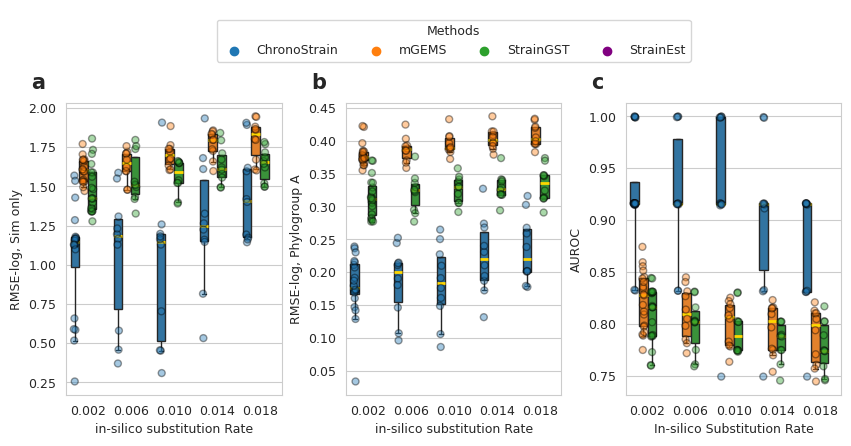

In [138]:
sb.set_style("whitegrid")

fig = plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 9})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
gs = gridspec.GridSpec(ncols=3, nrows=2, figure=fig, height_ratios=[1, 10], hspace=0.4, wspace=0.3)


method_order = ['ChronoStrain', 'mGEMS', 'StrainGST', 'StrainEst']
colors = sb.color_palette("tab10")
method_palette = {
    'ChronoStrain': colors[0],
    'mGEMS': colors[1],
    'mGEMS-h': 'orangered',
    'StrainGST': colors[2],
    'StrainEst': 'purple',
}


legend_ax = fig.add_subplot(gs[0, :])
handles, labels = zip(*[
    (legend_ax.scatter([], [], facecolors=method_palette[m]), m) 
    for m in method_order
])
method_legend = legend_ax.legend(handles, labels, title="Methods", bbox_to_anchor=(0.5, -1), loc="lower center", ncol=len(method_order))
legend_ax.axis('off')

axes = []
x_order = sorted(pd.unique(mutratio_err_df['MutRatio']))

ax = fig.add_subplot(gs[1, 0])
sb.stripplot(mutratio_err_df, x='MutRatio', order=x_order, y='RMSErrorSim', hue='Method', dodge=True, ax=ax, legend=False, edgecolor='black', linewidth=1.0, alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(mutratio_err_df, x='MutRatio', order=x_order, y='RMSErrorSim', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
ax.set_xlabel('in-silico substitution Rate')
ax.set_ylabel("RMSE-log, Sim only")
ax.legend([],[], frameon=False)
axes.append(ax)

ax = fig.add_subplot(gs[1, 1])
sb.stripplot(mutratio_err_df, x='MutRatio', order=x_order, y='RMSErrorA', hue='Method', dodge=True, ax=ax, legend=False, edgecolor='black', linewidth=1.0, alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(mutratio_err_df, x='MutRatio', order=x_order, y='RMSErrorA', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
ax.set_xlabel('in-silico substitution Rate')
ax.set_ylabel("RMSE-log, Phylogroup A")
ax.legend([],[], frameon=False)
axes.append(ax)

ax = fig.add_subplot(gs[1, 2])
sb.stripplot(mutratio_err_df, x='MutRatio', order=x_order, y='AUROC', hue='Method', dodge=True, ax=ax, legend=False, edgecolor='black', linewidth=1.0, alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(mutratio_err_df, x='MutRatio', order=x_order, y='AUROC', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
ax.set_xlabel('In-silico Substitution Rate')
ax.set_ylabel("AUROC")
ax.legend([],[], frameon=False)
axes.append(ax)





add_figure_labels(fig, axes, list('abc'))

plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)

fig.tight_layout()
plt.savefig(plots_dir / 'semisynthetic-mutratios.pdf', format='pdf', bbox_inches='tight')